# FashionMNIST VAE

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torchvision
import torchvision.transforms as tvt
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, Adamax, Adadelta, SGD, RMSprop
from torchvision import utils
from helper_functions import *
from sklearn.manifold import TSNE
from PIL import Image

### Define the simulation parameters

In [2]:
params = { 
    'CHANNELS' : 1,
    'WIDTH' : 28,
    'HEIGHT':28, 
    'DIM_Z':20,
    'SCALE': 1.0,
    'use_cuda' : torch.cuda.is_available()
    }
print(params)

{'use_cuda': True, 'SCALE': 1.0, 'HEIGHT': 28, 'WIDTH': 28, 'DIM_Z': 20, 'CHANNELS': 1}


### Get the data

torch.Size([4, 1, 28, 28])


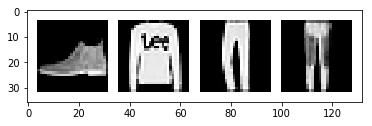

In [3]:
BATCH_SIZE = 512
kwargs = {'num_workers': 0, 'pin_memory': params["use_cuda"]}
data_dir = "/home/jupyter/REPOS/VAE_PYRO"
#data_dir = "/home/ldalessi/REPOS/VAE_PYRO"
#data_dir = "/Users/ldalessi/VAE_PYRO"


trainset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True, transform=tvt.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
testset = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True, transform=tvt.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

imgs_test,labels = next(iter(testloader))
if(params['use_cuda']):
    imgs_test=imgs_test[:4].cuda()

print(imgs_test.shape)
show_batch(imgs_test,npadding=4)

# VAE in PYTORCH

In [4]:
from encoder_decoder import *
from vae import *
encoder = Encoder_CONV(params)
decoder = Decoder_CONV(params)
vae = VAE(params,encoder,decoder)

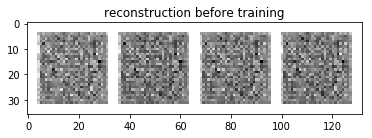

In [5]:
imgs_rec = vae.reconstruct(imgs_test)
show_batch(imgs_rec,nrow=4,npadding=4,title="reconstruction before training")
plt.savefig("rec_before_training.png")

In [6]:
pt_optimizer = torch.optim.RMSprop(vae.parameters(),lr=1E-6)
pt_scheduler = torch.optim.lr_scheduler.StepLR(pt_optimizer, step_size=1, gamma=1.5, last_epoch=-1)

pt_hist_loss = []
pt_hist_lr = []
#for epoch in range(30):
for epoch in range(-1):
    loss_curr = train_VAE_pytorch(vae, trainloader, pt_optimizer, use_cuda = params['use_cuda'], verbose=(epoch==-1))
    lr_curr   = pt_optimizer.param_groups[0]['lr']
    print("[epoch %03d] train loss: %.4f lr: %.4e" % (epoch, loss_curr, lr_curr))
    pt_hist_loss.append(loss_curr)  
    pt_hist_lr.append(lr_curr)
    pt_scheduler.step()
    if(np.isnan(loss_curr)):
        break 
        
    imgs_rec = vae.reconstruct(imgs_test)
    show_batch(imgs_rec,nrow=4,npadding=4,title="epoch = "+str(epoch))
    plt.savefig("PYTORCH_rec_epoch_"+str(epoch)+".png")

### Show pytorch results

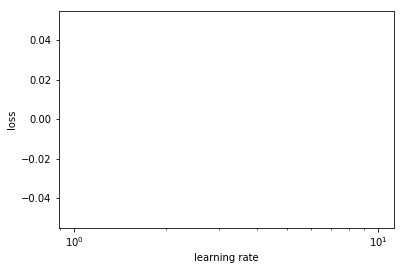

In [7]:
plt.xscale('log')
plt.plot(pt_hist_lr,pt_hist_loss,'.--')
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.savefig("PYTORCH_train.png")

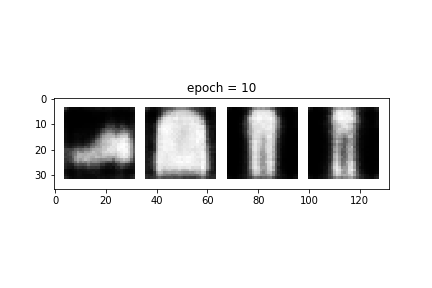

In [8]:
#intermediate reconstrucxtion
epoch = 10
path="./PYTORCH_rec_epoch_"+str(epoch)+".png"
display(Image.open(path))

# VAE in PYRO

In [18]:
from encoder_decoder import *
from vae import *
encoder = Encoder_CONV(params)
decoder = Decoder_CONV(params)
vae = VAE(params,encoder,decoder)

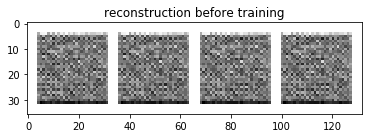

In [19]:
imgs_rec = vae.reconstruct(imgs_test)
show_batch(imgs_rec,nrow=4,npadding=4,title="reconstruction before training")
plt.savefig("rec_before_training.png")

In [20]:
pyro.clear_param_store()
pyro.set_rng_seed(0)

optimizer_args = {'lr': 1E-6}
scheduler_args = {'optimizer': torch.optim.RMSprop, 'step_size' : 1, 'gamma' : 1.5, 'optim_args' : optimizer_args}

pyro_scheduler = pyro.optim.StepLR(scheduler_args)
svi = SVI(vae.model, vae.guide, pyro_scheduler, loss=Trace_ELBO(num_particles=1))

[epoch 000] train loss: 1874.1047 lr: 1.0000e-04
[epoch 001] train loss: 416.0864 lr: 1.0000e-04
[epoch 002] train loss: 114.2235 lr: 1.0000e-04
[epoch 003] train loss: -24.1948 lr: 1.0000e-04
[epoch 004] train loss: -116.5359 lr: 1.0000e-04
[epoch 005] train loss: -185.5304 lr: 1.0000e-04
[epoch 006] train loss: -236.1222 lr: 1.0000e-04
[epoch 007] train loss: -271.2336 lr: 1.0000e-04
[epoch 008] train loss: -303.9623 lr: 1.0000e-04
[epoch 009] train loss: -326.6211 lr: 1.0000e-04
[epoch 010] train loss: -348.5216 lr: 1.0000e-04
[epoch 011] train loss: -367.2677 lr: 1.0000e-04
[epoch 012] train loss: -384.1172 lr: 1.0000e-04
[epoch 013] train loss: -398.1652 lr: 1.0000e-04


KeyboardInterrupt: 

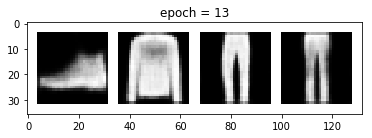

In [21]:
# preparation
hist_loss = []
hist_lr = []
    
for epoch in range(0,30):
    
    loss_curr = train(svi, trainloader, use_cuda=params['use_cuda'], verbose=False)
    lr_curr   = pyro_scheduler.pt_optim_args['lr']
    print("[epoch %03d] train loss: %.4f lr: %.4e" % (epoch, loss_curr, lr_curr))
    pt_hist_loss.append(loss_curr)  
    pt_hist_lr.append(lr_curr)
    pt_scheduler.step()
    if(np.isnan(loss_curr)):
        break 
        
    imgs_rec = vae.reconstruct(imgs_test)
    show_batch(imgs_rec,nrow=4,npadding=4,title="epoch = "+str(epoch))
    plt.savefig("PYRO_rec_epoch_"+str(epoch)+".png")

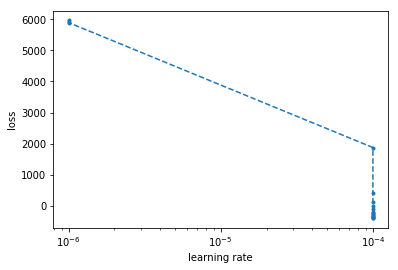

In [22]:
plt.xscale('log')
plt.plot(pt_hist_lr,pt_hist_loss,'.--')
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.savefig("PYRO_train.png")

In [ ]:
epoch = 10
path="./PYTORCH_rec_epoch_"+str(epoch)+".png"
display(Image.open(path))